In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from vivarium import Artifact

from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import StrMethodFormatter


!date
!whoami
!pwd

Wed Nov 12 08:39:16 PST 2025
tylerdy
/mnt/share/homes/tylerdy/vivarium_research_alzheimers/plots


In [3]:
results_dir = "/snfs1/Project/simulation_science/alzheimers/results_10_31_2025"
inc = pd.read_csv(Path(results_dir) / "incidence.csv")
prev = pd.read_csv(Path(results_dir) / "prevalence.csv")
deaths = pd.read_csv(Path(results_dir) / "deaths.csv")
res = pd.concat([prev, inc, deaths])
res

,Year,Location,Age,Sex,Disease Stage,Scenario,Measure,Metric,Mean,95% UI Lower,95% UI Upper
0,2025,Brazil,25_to_29,Female,Preclinical AD,Reference,Prevalence,Number,0.000000,0.000000,0.000000
1,2025,Brazil,25_to_29,Female,MCI due to AD,Reference,Prevalence,Number,0.000000,0.000000,0.000000
2,2025,Brazil,25_to_29,Female,AD Dementia,Reference,Prevalence,Number,0.000000,0.000000,0.000000
3,2025,Brazil,25_to_29,Male,Preclinical AD,Reference,Prevalence,Number,0.000000,0.000000,0.000000
4,2025,Brazil,25_to_29,Male,MCI due to AD,Reference,Prevalence,Number,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
113995,2100,United States of America,95_plus,Male,AD Dementia,BBBM Testing and Treatment,Deaths Associated with AD,Number,7764.612990,5466.617453,10079.971108
113996,2100,United States of America,95_plus,Female,AD Dementia,BBBM Testing Only,Averted Deaths Associated with AD,Number,0.000000,0.000000,0.000000
113997,2100,United States of America,95_plus,Male,AD Dementia,BBBM Testing Only,Averted Deaths Associated with AD,Number,0.000000,0.000000,0.000000
113998,2100,United States of America,95_plus,Female,AD Dementia,BBBM Testing and Treatment,Averted Deaths Associated with AD,Number,-81.315146,-138.475470,-37.700393


In [179]:
def filter_results(
    df,
    keep_stratified,
    year=None,
    location=None,
    age=None,
    sex=None,
    stage=None,
    scenario=["Reference"],
    measure=None,
    metric=["Number"],
):
    cols = {
        "Year": year,
        "Location": location,
        "Age": age,
        "Sex": sex,
        "Disease Stage": stage,
        "Scenario": scenario,
        "Measure": measure,
        "Metric": metric,
    }
    num_cols = ["Mean", "95% UI Lower", "95% UI Upper"]
    for col_name, filter_vals in cols.items():
        if col_name not in df.columns:
            continue
        if filter_vals:
            df = df[df[col_name].isin(filter_vals)]
        elif col_name not in keep_stratified:
            df = (
                df.groupby(
                    list(df.columns.difference(num_cols + [col_name], sort=False))
                )
                .sum()
                .reset_index()
                .drop(col_name, axis=1)
            )
    if "Age" in df.columns:
        # some ages are wrong
        df["Age"] = df["Age"].replace(
            {
                "20_to_25": "20_to_24",
                "25_to_30": "25_to_29",
                "30_to_35": "30_to_34",
                "35_to_40": "35_to_39",
                "40_to_45": "40_to_44",
                "45_to_50": "45_to_49",
                "50_to_55": "50_to_54",
                "55_to_60": "55_to_59",
                "60_to_65": "60_to_64",
                "65_to_70": "65_to_69",
                "70_to_75": "70_to_74",
                "75_to_80": "75_to_79",
                "80_to_85": "80_to_84",
                "85_to_90": "85_to_89",
                "90_to_95": "90_to_94",
            }
        )
        df["Age"] = df["Age"].replace(
            [
                "20_to_24",
                "25_to_29",
                "30_to_34",
                "35_to_39",
                "40_to_44",
                "45_to_49",
                "50_to_54",
                "55_to_59",
            ],
            "20_to_59",
        )
        df = (
            df.groupby(list(df.columns.difference(num_cols, sort=False)))
            .sum()
            .reset_index()
        )
    return df


# Note: Can filter out some values for a column, but then still sum them and remove the stratification by using multiple passes

In [193]:
def ax_over_time(plot_data, lbl):

    ax = plt.gca()
    ax.plot(plot_data["Year"], plot_data["Mean"], label=lbl)
    if {"95% UI Lower", "95% UI Upper"}.issubset(plot_data.columns):
        ax.fill_between(
            plot_data["Year"],
            plot_data["95% UI Lower"],
            plot_data["95% UI Upper"],
            alpha=0.2,
        )


def plot_over_time(title: str, ylabel: str, min, max, scale="linear"):
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2025, 2101, 10))
    plt.yscale(scale)
    if scale == "linear" and min >= 0:
        plt.ylim(bottom=0)
    if max > 1:
        formatter = StrMethodFormatter("{x:,.0f}")
        plt.gca().yaxis.set_major_formatter(formatter)
    plt.legend(loc=(1.01, 0))
    plt.figure()


def make_forecast_plot(data, title, ylabel, strat_col="Location", scale="linear"):
    for strat_val in data[strat_col].unique():
        df = data[data[strat_col] == strat_val]
        ax_over_time(df, strat_val)
    plot_over_time(
        title, ylabel, np.nanmin(data["Mean"]), np.nanmax(data["Mean"]), scale
    )

# Baseline (Health and Forecasting) Results

Possible TODOs:
* Rates
* Most plots level out around 2050 - is it ok to show through 2100
* Add age group distribution bar graph for US in 2025, 2037, 2050
* Dashed lines for younger half of age groups in line graphs

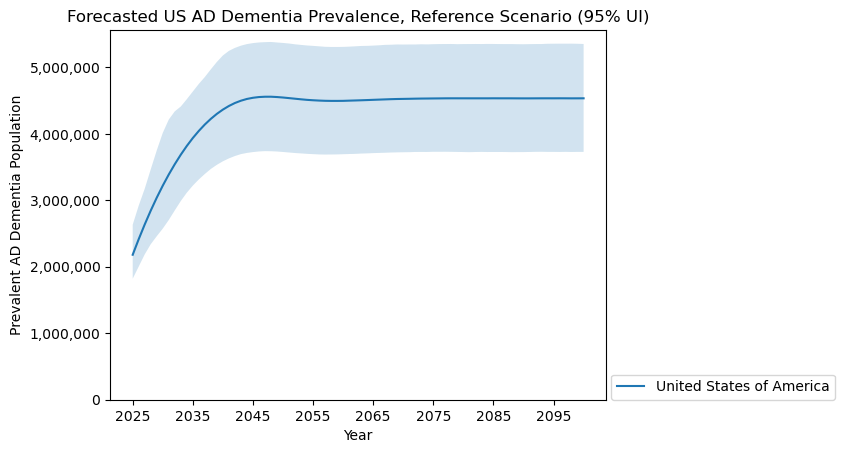

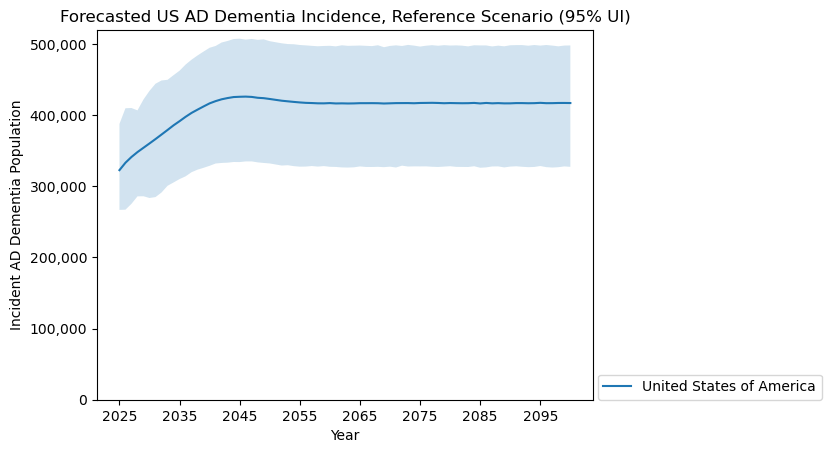

<Figure size 640x480 with 0 Axes>

In [180]:
make_forecast_plot(
    filter_results(
        res,
        ["Year"],
        location=["United States of America"],
        stage=["AD Dementia"],
        measure=["Prevalence"],
    ),
    "Forecasted US AD Dementia Prevalence, Reference Scenario (95% UI)",
    "Prevalent AD Dementia Population",
)
make_forecast_plot(
    filter_results(
        res,
        ["Year"],
        location=["United States of America"],
        stage=["AD Dementia"],
        measure=["Incidence"],
    ),
    "Forecasted US AD Dementia Incidence, Reference Scenario (95% UI)",
    "Incident AD Dementia Population",
)

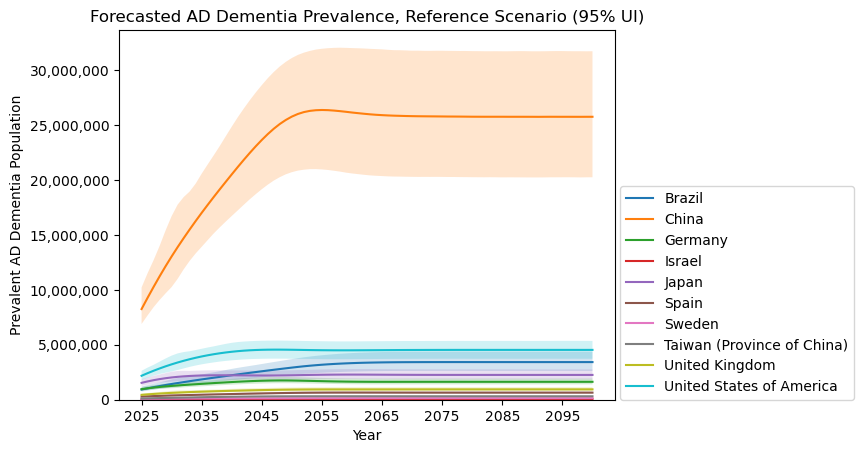

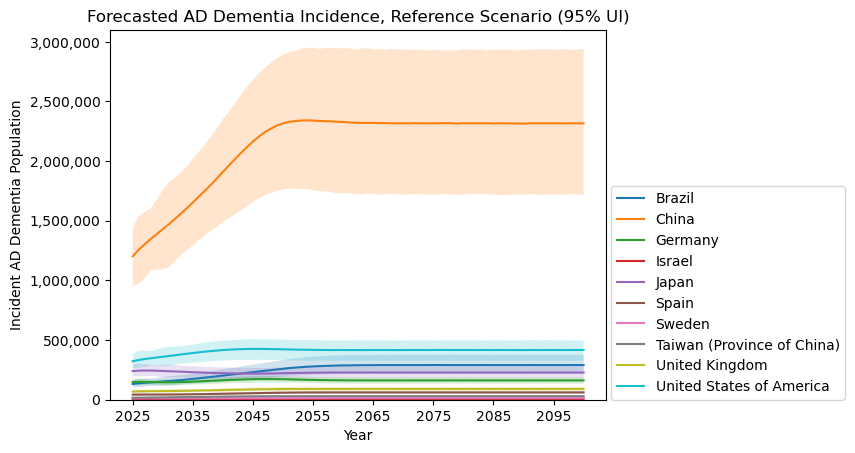

<Figure size 640x480 with 0 Axes>

In [47]:
make_forecast_plot(
    filter_results(
        res,
        ["Year", "Location"],
        stage=["AD Dementia"],
        measure=["Prevalence"],
    ),
    "Forecasted AD Dementia Prevalence, Reference Scenario (95% UI)",
    "Prevalent AD Dementia Population",
)
make_forecast_plot(
    filter_results(
        res,
        ["Year", "Location"],
        stage=["AD Dementia"],
        measure=["Incidence"],
    ),
    "Forecasted AD Dementia Incidence, Reference Scenario (95% UI)",
    "Incident AD Dementia Population",
)

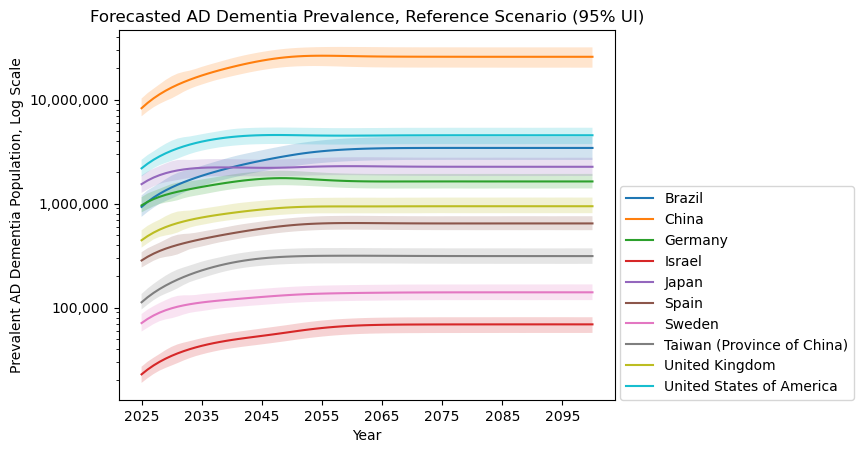

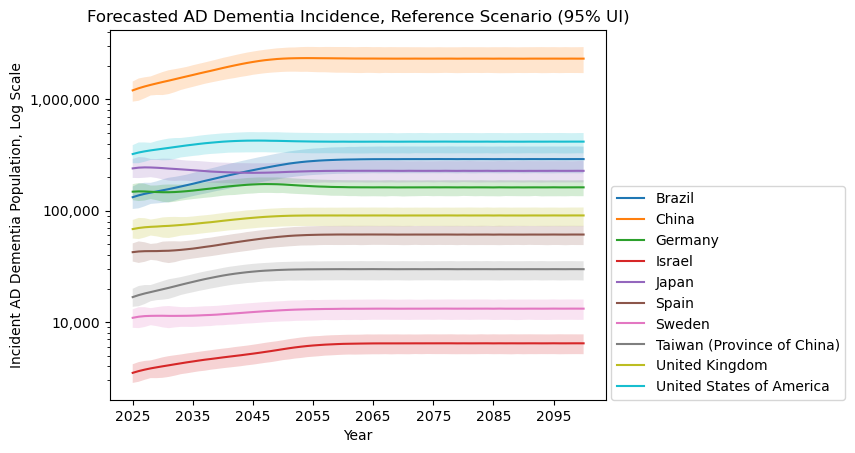

<Figure size 640x480 with 0 Axes>

In [48]:
make_forecast_plot(
    filter_results(
        res,
        ["Year", "Location"],
        stage=["AD Dementia"],
        measure=["Prevalence"],
    ),
    "Forecasted AD Dementia Prevalence, Reference Scenario (95% UI)",
    "Prevalent AD Dementia Population, Log Scale",
    scale="log",
)
make_forecast_plot(
    filter_results(
        res,
        ["Year", "Location"],
        stage=["AD Dementia"],
        measure=["Incidence"],
    ),
    "Forecasted AD Dementia Incidence, Reference Scenario (95% UI)",
    "Incident AD Dementia Population, Log Scale",
    scale="log",
)

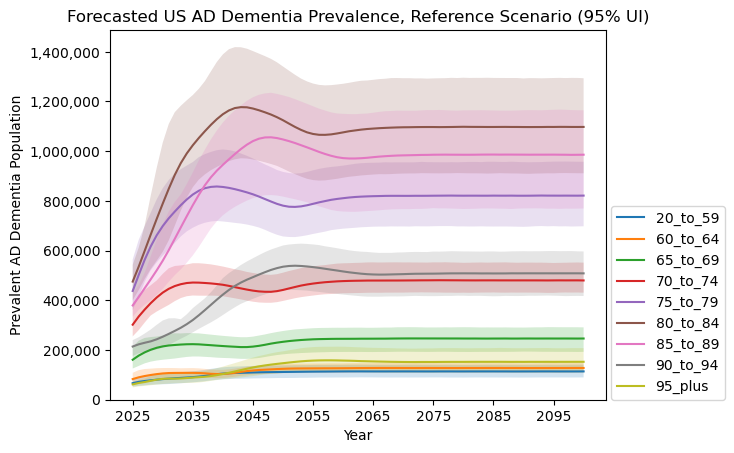

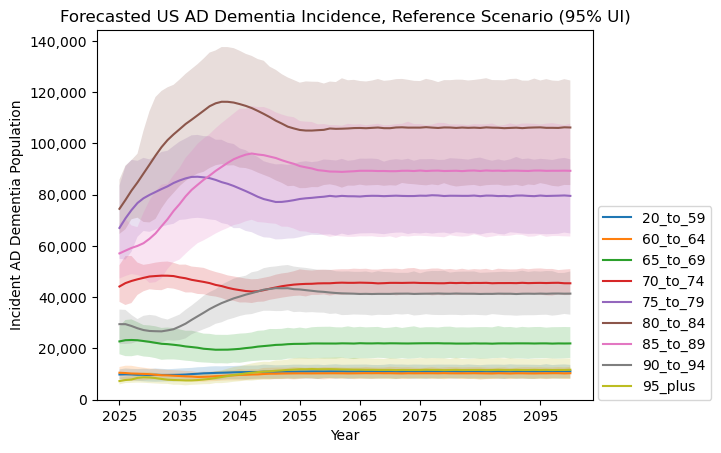

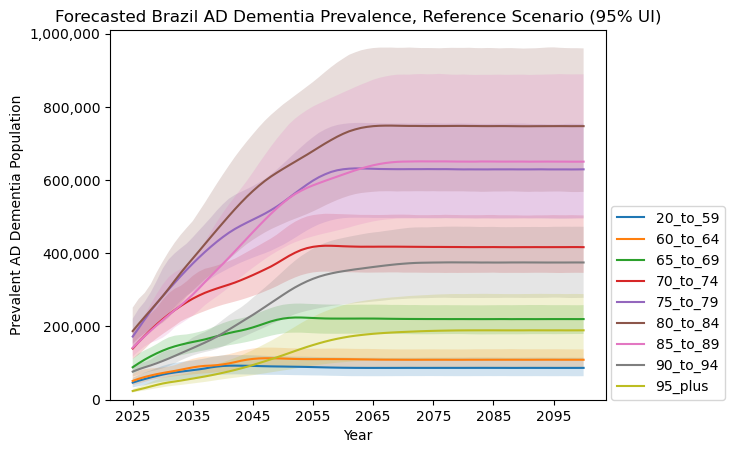

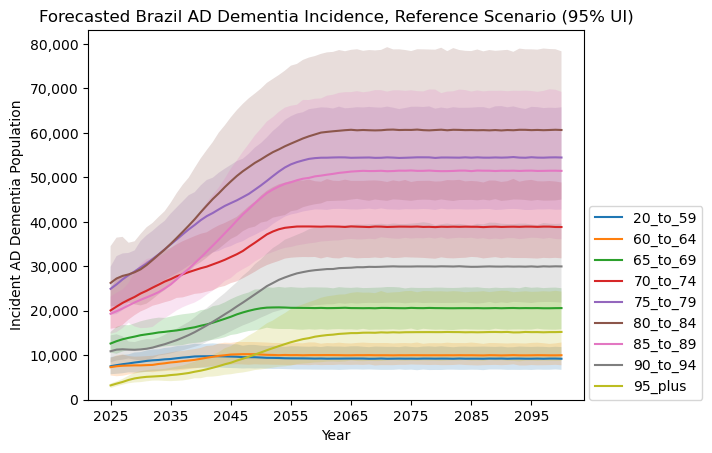

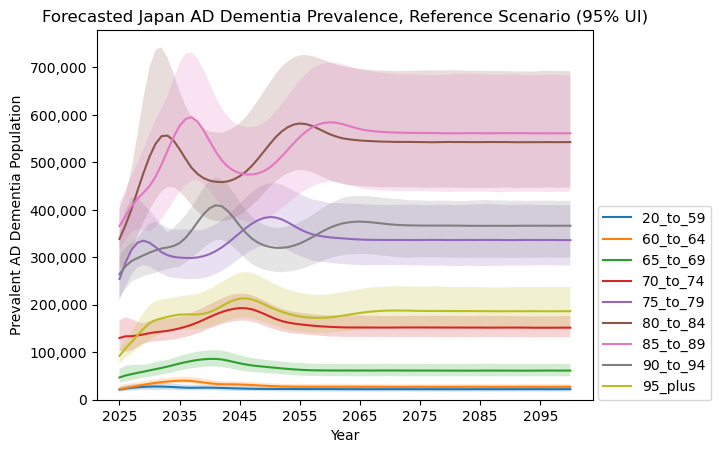

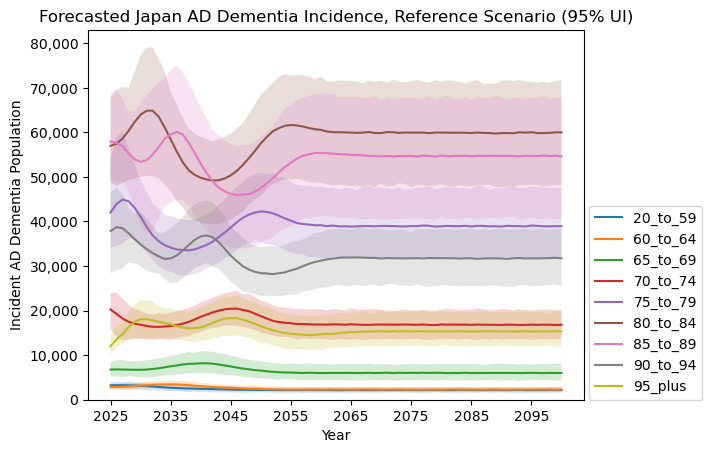

<Figure size 640x480 with 0 Axes>

In [49]:
make_forecast_plot(
    filter_results(
        res,
        ["Year", "Age"],
        location=["United States of America"],
        stage=["AD Dementia"],
        measure=["Prevalence"],
    ),
    "Forecasted US AD Dementia Prevalence, Reference Scenario (95% UI)",
    "Prevalent AD Dementia Population",
    strat_col="Age",
)
make_forecast_plot(
    filter_results(
        res,
        ["Year", "Age"],
        location=["United States of America"],
        stage=["AD Dementia"],
        measure=["Incidence"],
    ),
    "Forecasted US AD Dementia Incidence, Reference Scenario (95% UI)",
    "Incident AD Dementia Population",
    strat_col="Age",
)
make_forecast_plot(
    filter_results(
        res,
        ["Year", "Age"],
        location=["Brazil"],
        stage=["AD Dementia"],
        measure=["Prevalence"],
    ),
    "Forecasted Brazil AD Dementia Prevalence, Reference Scenario (95% UI)",
    "Prevalent AD Dementia Population",
    strat_col="Age",
)
make_forecast_plot(
    filter_results(
        res,
        ["Year", "Age"],
        location=["Brazil"],
        stage=["AD Dementia"],
        measure=["Incidence"],
    ),
    "Forecasted Brazil AD Dementia Incidence, Reference Scenario (95% UI)",
    "Incident AD Dementia Population",
    strat_col="Age",
)
make_forecast_plot(
    filter_results(
        res,
        ["Year", "Age"],
        location=["Japan"],
        stage=["AD Dementia"],
        measure=["Prevalence"],
    ),
    "Forecasted Japan AD Dementia Prevalence, Reference Scenario (95% UI)",
    "Prevalent AD Dementia Population",
    strat_col="Age",
)
make_forecast_plot(
    filter_results(
        res,
        ["Year", "Age"],
        location=["Japan"],
        stage=["AD Dementia"],
        measure=["Incidence"],
    ),
    "Forecasted Japan AD Dementia Incidence, Reference Scenario (95% UI)",
    "Incident AD Dementia Population",
    strat_col="Age",
)

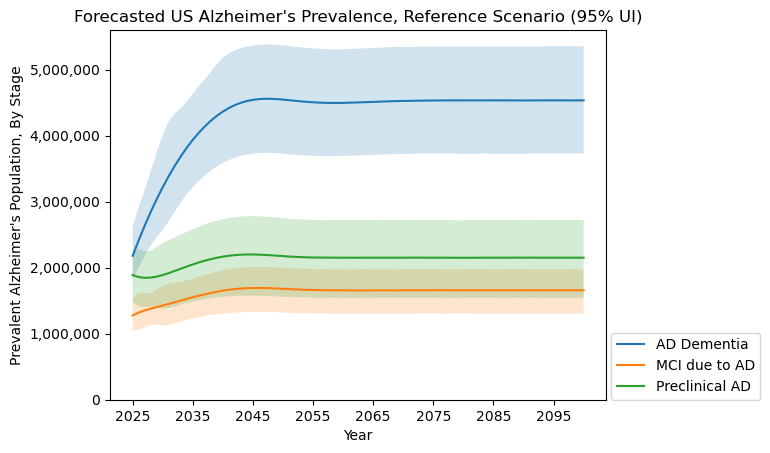

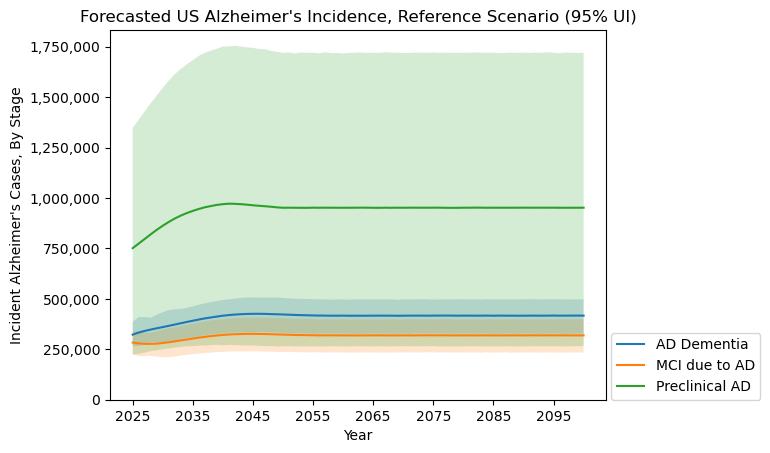

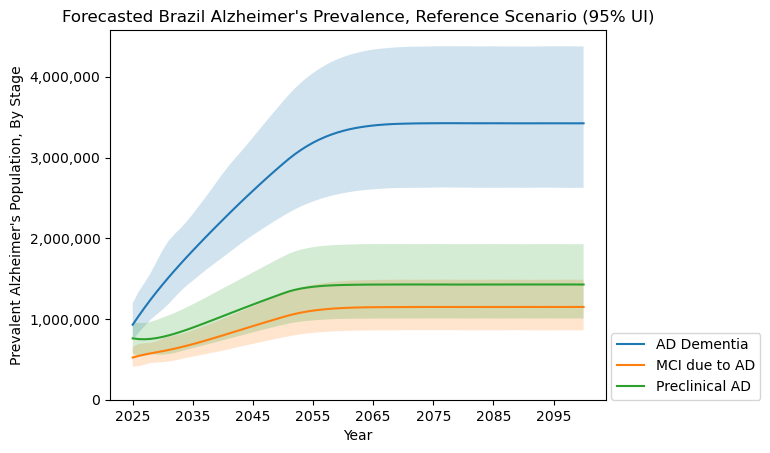

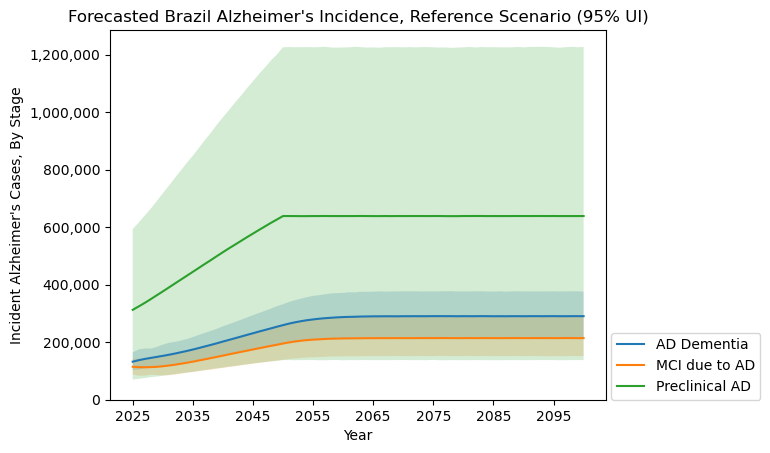

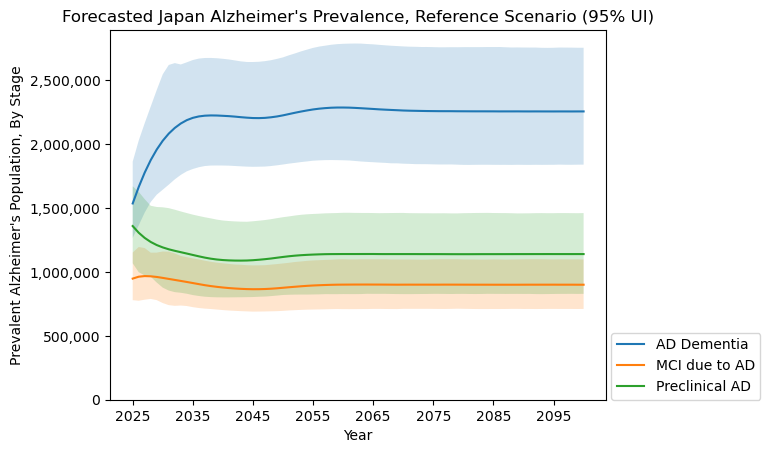

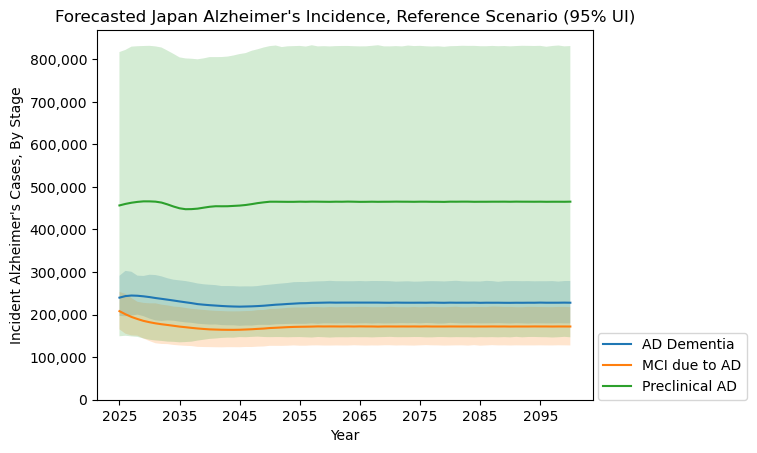

<Figure size 640x480 with 0 Axes>

In [50]:
make_forecast_plot(
    filter_results(
        res,
        ["Year", "Disease Stage"],
        location=["United States of America"],
        measure=["Prevalence"],
    ),
    "Forecasted US Alzheimer's Prevalence, Reference Scenario (95% UI)",
    "Prevalent Alzheimer's Population, By Stage",
    strat_col="Disease Stage",
)
make_forecast_plot(
    filter_results(
        res,
        ["Year", "Disease Stage"],
        location=["United States of America"],
        measure=["Incidence"],
    ),
    "Forecasted US Alzheimer's Incidence, Reference Scenario (95% UI)",
    "Incident Alzheimer's Cases, By Stage",
    strat_col="Disease Stage",
)
make_forecast_plot(
    filter_results(
        res,
        ["Year", "Disease Stage"],
        location=["Brazil"],
        measure=["Prevalence"],
    ),
    "Forecasted Brazil Alzheimer's Prevalence, Reference Scenario (95% UI)",
    "Prevalent Alzheimer's Population, By Stage",
    strat_col="Disease Stage",
)
make_forecast_plot(
    filter_results(
        res,
        ["Year", "Disease Stage"],
        location=["Brazil"],
        measure=["Incidence"],
    ),
    "Forecasted Brazil Alzheimer's Incidence, Reference Scenario (95% UI)",
    "Incident Alzheimer's Cases, By Stage",
    strat_col="Disease Stage",
)
make_forecast_plot(
    filter_results(
        res,
        ["Year", "Disease Stage"],
        location=["Japan"],
        measure=["Prevalence"],
    ),
    "Forecasted Japan Alzheimer's Prevalence, Reference Scenario (95% UI)",
    "Prevalent Alzheimer's Population, By Stage",
    strat_col="Disease Stage",
)
make_forecast_plot(
    filter_results(
        res,
        ["Year", "Disease Stage"],
        location=["Japan"],
        measure=["Incidence"],
    ),
    "Forecasted Japan Alzheimer's Incidence, Reference Scenario (95% UI)",
    "Incident Alzheimer's Cases, By Stage",
    strat_col="Disease Stage",
)

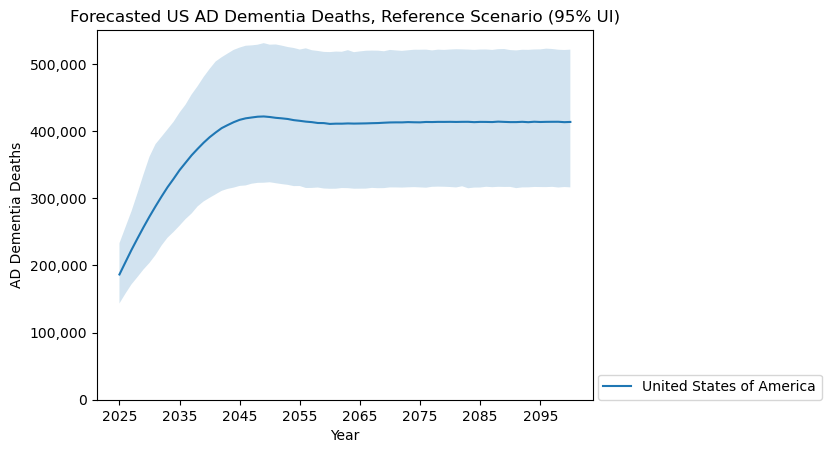

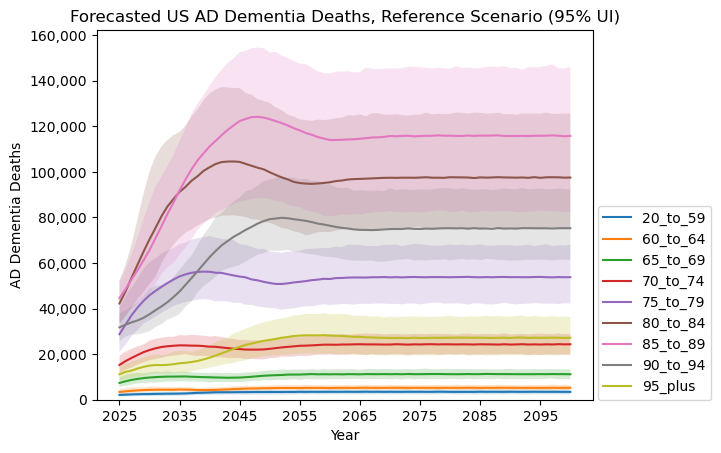

<Figure size 640x480 with 0 Axes>

In [51]:
make_forecast_plot(
    filter_results(
        res,
        ["Year"],
        location=["United States of America"],
        measure=["Deaths Associated with AD"],
    ),
    "Forecasted US AD Dementia Deaths, Reference Scenario (95% UI)",
    "AD Dementia Deaths",
)
make_forecast_plot(
    filter_results(
        res,
        ["Year", "Age"],
        location=["United States of America"],
        measure=["Deaths Associated with AD"],
    ),
    "Forecasted US AD Dementia Deaths, Reference Scenario (95% UI)",
    "AD Dementia Deaths",
    "Age",
)

# Testing

In [52]:
csf_pet = pd.read_csv(Path(results_dir) / "csf_pet_tests.csv")
bbbm = pd.read_csv(Path(results_dir) / "bbbm_tests.csv")
res2 = pd.concat([csf_pet, bbbm])
res2

,Year,Location,Age,Sex,Disease Stage,Scenario,Measure,Metric,Mean,95% UI Lower,95% UI Upper
0,2025,Brazil,25_to_29,Female,MCI due to AD,Reference,Averted CSF Tests,Number,0.000000,0.000000,0.000000
1,2025,Brazil,25_to_29,Female,MCI due to AD,Reference,Averted PET Tests,Number,0.000000,0.000000,0.000000
2,2025,Brazil,25_to_29,Female,MCI due to AD,Reference,CSF Tests,Number,0.000000,0.000000,0.000000
3,2025,Brazil,25_to_29,Female,MCI due to AD,Reference,PET Tests,Number,0.000000,0.000000,0.000000
4,2025,Brazil,25_to_29,Female,MCI due to AD,BBBM Testing Only,Averted CSF Tests,Number,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
79655,2100,United States of America,75_to_80,Female,Susceptible,BBBM Testing and Treatment,BBBM False Positive Tests,Number,146774.863478,136236.289374,154975.735010
79656,2100,United States of America,60_to_65,Male,Susceptible,BBBM Testing and Treatment,BBBM False Positive Tests,Number,231725.331175,215371.159718,244914.562719
79657,2100,United States of America,65_to_70,Male,Susceptible,BBBM Testing and Treatment,BBBM False Positive Tests,Number,187697.518252,174450.639371,198380.795803
79658,2100,United States of America,70_to_75,Male,Susceptible,BBBM Testing and Treatment,BBBM False Positive Tests,Number,80018.415676,74371.062048,84572.865579


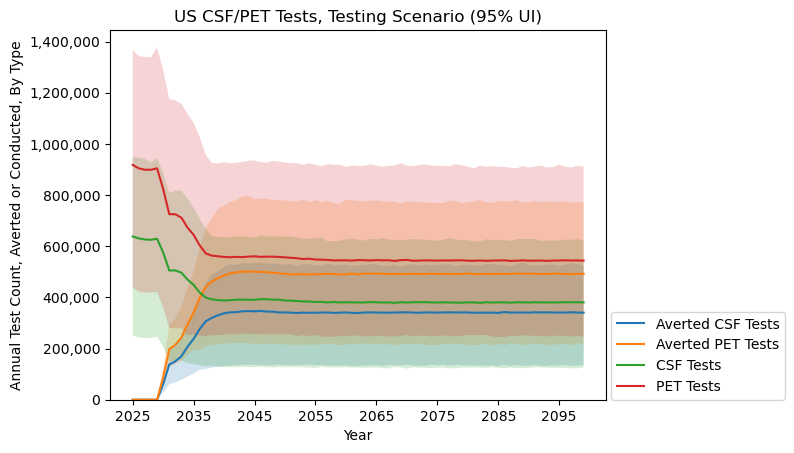

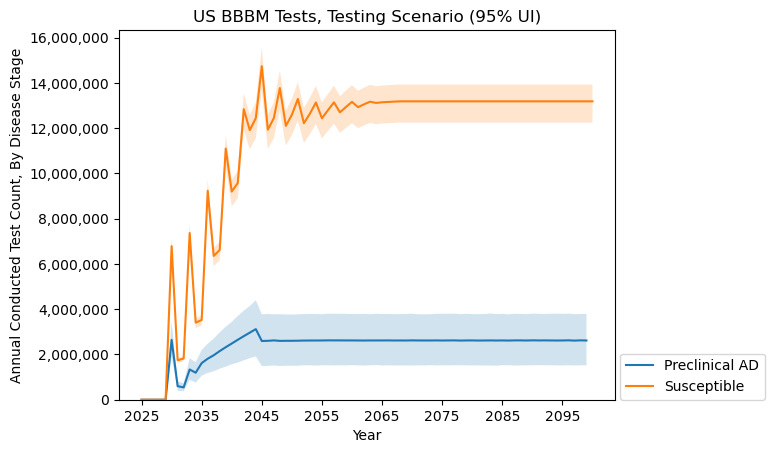

<Figure size 640x480 with 0 Axes>

In [189]:
make_forecast_plot(
    filter_results(
        res2,
        ["Year"],
        location=["United States of America"],
        measure=[
            "Averted CSF Tests",
            "Averted PET Tests",
            "CSF Tests",
            "PET Tests",
        ],  # BBBM Tests results in this scenario dont yet include MSLT
        scenario=["BBBM Testing Only"],
    ),
    "US CSF/PET Tests, Testing Scenario (95% UI)",
    "Annual Test Count, Averted or Conducted, By Type",
    "Measure",
)

make_forecast_plot(
    filter_results(
        res2,
        ["Year", "Disease Stage"],
        location=["United States of America"],
        measure=["BBBM Tests"],
        scenario=["BBBM Testing and Treatment"],
    ),
    "US BBBM Tests, Testing Scenario (95% UI)",
    "Annual Conducted Test Count, By Disease Stage",
    "Disease Stage",
)

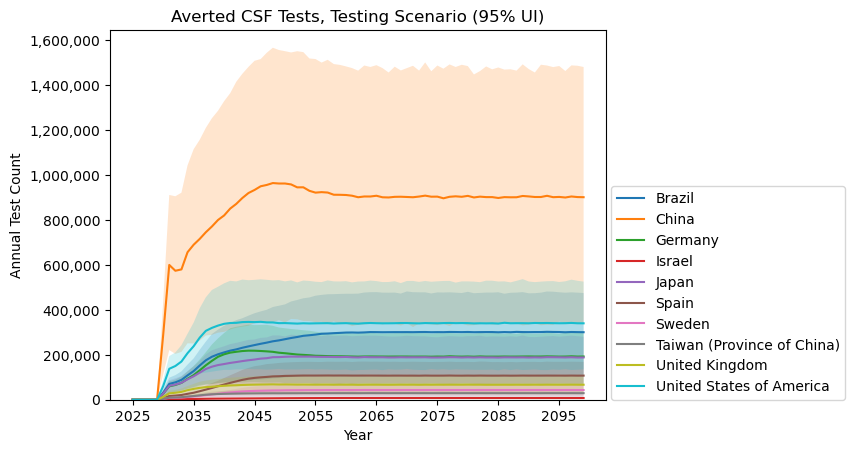

<Figure size 640x480 with 0 Axes>

In [54]:
make_forecast_plot(
    filter_results(
        res2,
        ["Year", "Location"],
        measure=["Averted CSF Tests"],
        scenario=["BBBM Testing Only"],
    ),
    "Averted CSF Tests, Testing Scenario (95% UI)",
    "Annual Test Count",
)

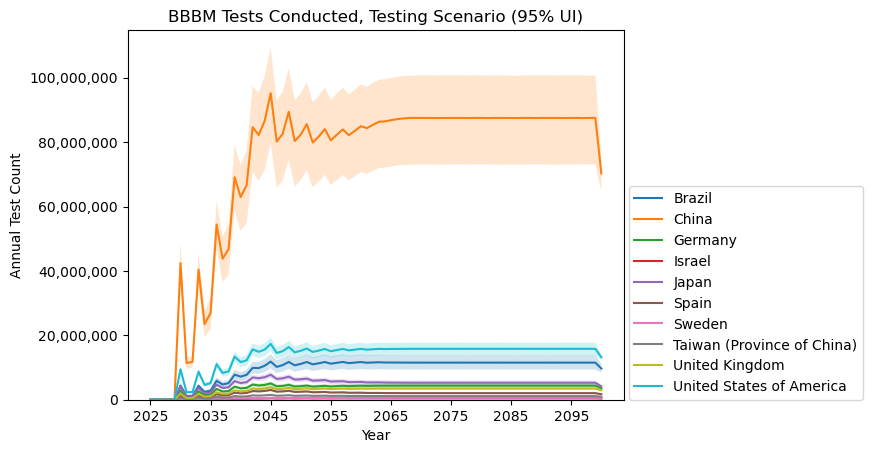

<Figure size 640x480 with 0 Axes>

In [55]:
make_forecast_plot(
    filter_results(
        res2,
        ["Year", "Location"],
        measure=["BBBM Tests"],
        scenario=["BBBM Testing and Treatment"],
    ),
    "BBBM Tests Conducted, Testing Scenario (95% UI)",
    "Annual Test Count",
)

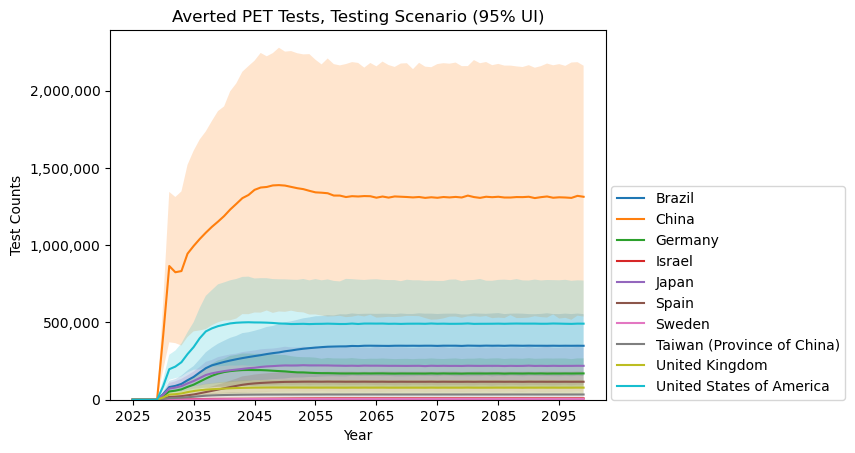

<Figure size 640x480 with 0 Axes>

In [56]:
make_forecast_plot(
    filter_results(
        res2,
        ["Year", "Location"],
        measure=["Averted PET Tests"],
        scenario=["BBBM Testing Only"],
    ),
    "Averted PET Tests, Testing Scenario (95% UI)",
    "Test Counts",
)

In [ ]:
# PPV, true pos, false neg estimated for now
def get_true_pos(strat_col="Measure"):
    df = filter_results(
        res2,
        ["Year", strat_col],
        location=["United States of America"],
        scenario=["BBBM Testing Only"],
        measure=["BBBM Tests"],  # for now this doesn't include MSLT
    )
    df["Measure"] = "BBBM Tests"

    pos_sim = (
        df.set_index(
            list(df.columns.difference(["Mean", "95% UI Lower", "95% UI Upper"]))
        )
        * 0.9  # estimated for now since we don't have actual pos test data
    ).drop(["95% UI Lower", "95% UI Upper"], axis=1)
    return pos_sim


def get_false_neg(strat_col="Measure"):
    df = filter_results(
        res2,
        ["Year", strat_col],
        location=["United States of America"],
        scenario=["BBBM Testing Only"],
        measure=["BBBM Tests"],  # for now this doesn't include MSLT
    )
    df["Measure"] = "BBBM Tests"

    neg_sim = (
        df.set_index(
            list(df.columns.difference(["Mean", "95% UI Lower", "95% UI Upper"]))
        )
        * 0.1  # estimated for now since we don't have actual pos test data
    ).drop(["95% UI Lower", "95% UI Upper"], axis=1)
    return neg_sim


def get_false_pos(strat_col="Measure"):
    df = filter_results(
        res2,
        ["Year", strat_col],
        location=["United States of America"],
        scenario=["BBBM Testing and Treatment"],
        measure=["BBBM False Positive Tests"],
    )
    df["Measure"] = "BBBM Tests"
    df["Scenario"] = "BBBM Testing Only"  # this is a hack for now
    if "Age" in df.columns:
        # age group names are messed up here
        df["Age"] = df["Age"].str.split("_").str.get(0).astype(int)
        df["Age"] = df["Age"].astype(str) + "_to_" + (df["Age"] + 4).astype(str)

    pos_mslt = df.set_index(
        list(df.columns.difference(["Mean", "95% UI Lower", "95% UI Upper"]))
    ).drop(["95% UI Lower", "95% UI Upper"], axis=1)
    return pos_mslt


def get_true_neg(strat_col="Measure"):
    # outside sim negatives = outside sim tests - outside sim positives

    df = filter_results(
        res2,
        ["Year", strat_col],
        location=["United States of America"],
        scenario=["BBBM Testing and Treatment"],
        stage=["Susceptible", "Preclinical AD"],
        measure=["BBBM Tests"],
    )
    # filter again to sum stages
    df = filter_results(
        df,
        ["Year", strat_col],
        location=["United States of America"],
        scenario=["BBBM Testing and Treatment"],
        measure=["BBBM Tests"],
    )
    df["Measure"] = "BBBM Tests"
    df["Scenario"] = "BBBM Testing Only"  # this is a hack for now

    all_mslt = df.set_index(
        list(df.columns.difference(["Mean", "95% UI Lower", "95% UI Upper"]))
    ).drop(["95% UI Lower", "95% UI Upper"], axis=1)

    return all_mslt - get_false_pos(strat_col)


def calc_ppv(strat_col="Measure"):
    true_pos = get_true_pos(strat_col)
    ppv = true_pos / (get_false_pos(strat_col) + true_pos)
    ppv = ppv.reset_index()
    ppv["Measure"] = "Positive Predictive Value"
    return ppv


def concat_all_tests(strat_col="Measure"):
    true_pos = get_true_pos(strat_col).reset_index()
    true_pos["Measure"] = "True Positive BBBM Tests"
    false_pos = get_false_pos(strat_col).reset_index()
    false_pos["Measure"] = "False Positive BBBM Tests"
    true_neg = get_true_neg(strat_col).reset_index()
    true_neg["Measure"] = "True Negative BBBM Tests"
    false_neg = get_false_neg(strat_col).reset_index()
    false_neg["Measure"] = "False Negative BBBM Tests"
    return pd.concat([true_pos, false_pos, true_neg, false_neg])

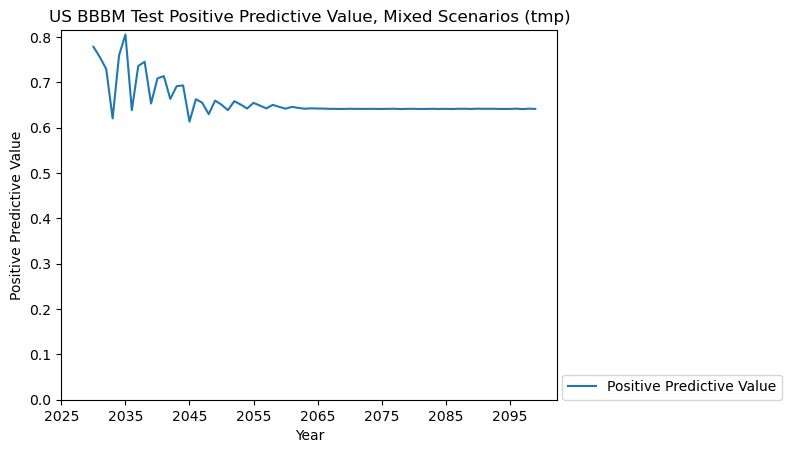

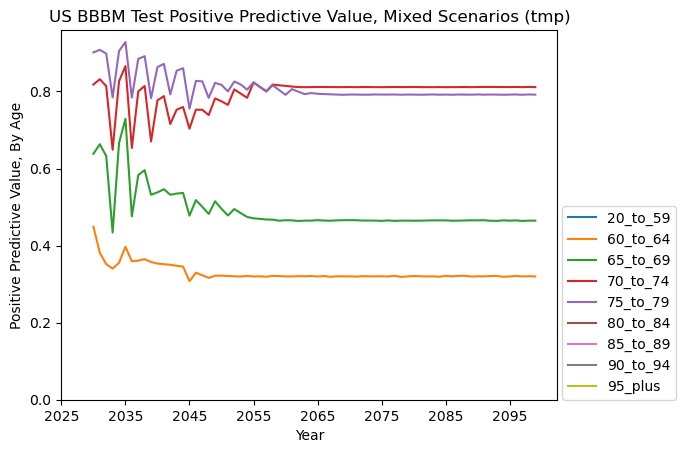

<Figure size 640x480 with 0 Axes>

In [186]:
make_forecast_plot(
    calc_ppv("Measure"),
    "US BBBM Test Positive Predictive Value, Mixed Scenarios (tmp)",
    "Positive Predictive Value",
    "Measure",
)
make_forecast_plot(
    calc_ppv("Age"),
    "US BBBM Test Positive Predictive Value, Mixed Scenarios (tmp)",
    "Positive Predictive Value, By Age",
    "Age",
)

# TBD need to filter by stage once Testing Only scenario includes susceptible tests

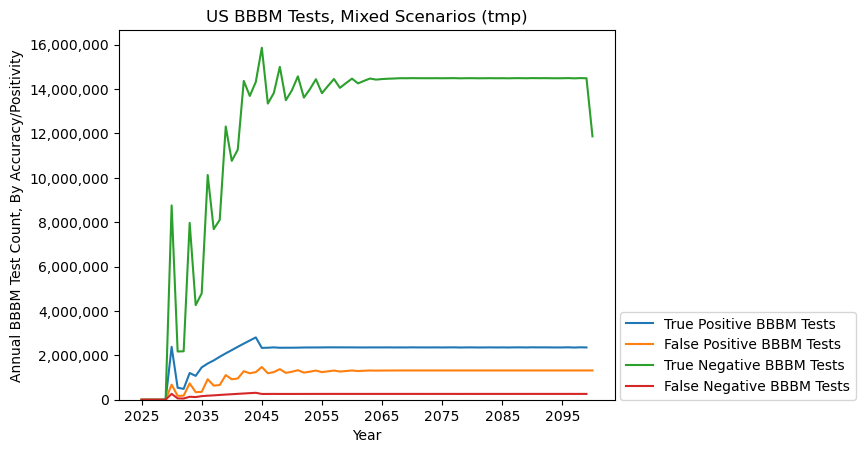

<Figure size 640x480 with 0 Axes>

In [187]:
make_forecast_plot(
    concat_all_tests(),
    "US BBBM Tests, Mixed Scenarios (tmp)",
    "Annual BBBM Test Count, By Accuracy/Positivity",
    "Measure",
)

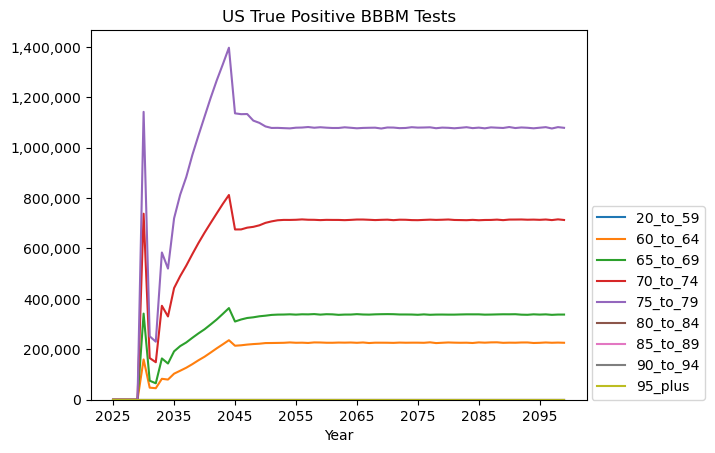

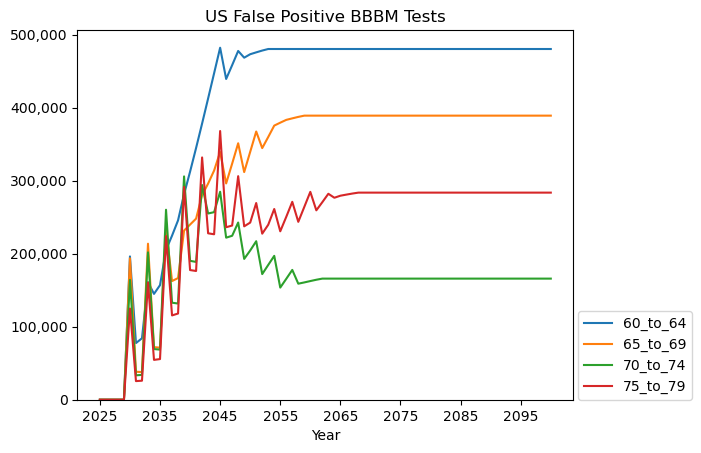

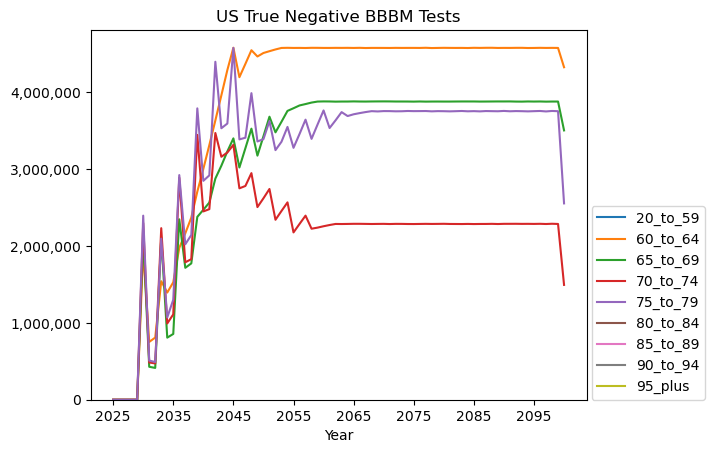

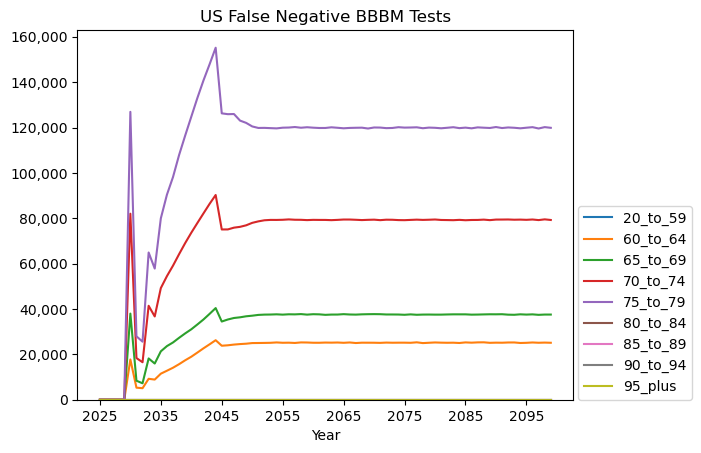

<Figure size 640x480 with 0 Axes>

In [194]:
make_forecast_plot(
    get_true_pos("Age").reset_index(), "US True Positive BBBM Tests", "", "Age"
)
make_forecast_plot(
    get_false_pos("Age").reset_index(), "US False Positive BBBM Tests", "", "Age"
)
make_forecast_plot(
    get_true_neg("Age").reset_index(), "US True Negative BBBM Tests", "", "Age"
)
make_forecast_plot(
    get_false_neg("Age").reset_index(), "US False Negative BBBM Tests", "", "Age"
)

# Treatment

In [59]:
dalys = pd.read_csv(Path(results_dir) / "dalys.csv")
deaths = pd.read_csv(Path(results_dir) / "deaths.csv")
medication = pd.read_csv(Path(results_dir) / "medication.csv")
res3 = pd.concat([dalys, deaths, medication])
display(res3["Measure"].unique())
res3

array(['DALYs Associated with AD', 'Averted DALYs Associated with AD',
       'Deaths Associated with AD', 'Averted Deaths Associated with AD',
       'Medication Completion', 'Medication Discontinuation',
       'Medication Initiation'], dtype=object)

,Year,Location,Age,Sex,Disease Stage,Scenario,Measure,Metric,Mean,95% UI Lower,95% UI Upper
0,2025,Brazil,25_to_29,Female,Preclinical AD,Reference,DALYs Associated with AD,Number,0.000000,0.000000,0.000000
1,2025,Brazil,25_to_29,Female,AD Dementia,Reference,DALYs Associated with AD,Number,0.000000,0.000000,0.000000
2,2025,Brazil,25_to_29,Female,MCI due to AD,Reference,DALYs Associated with AD,Number,0.000000,0.000000,0.000000
3,2025,Brazil,25_to_29,Male,Preclinical AD,Reference,DALYs Associated with AD,Number,0.000000,0.000000,0.000000
4,2025,Brazil,25_to_29,Male,AD Dementia,Reference,DALYs Associated with AD,Number,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
208575,2100,United States of America,75_to_80,Female,Susceptible,BBBM Testing and Treatment,Medication Initiation,Number,44032.459043,40870.886812,46492.720503
208576,2100,United States of America,60_to_65,Male,Susceptible,BBBM Testing and Treatment,Medication Initiation,Number,69517.599352,64611.347915,73474.368816
208577,2100,United States of America,65_to_70,Male,Susceptible,BBBM Testing and Treatment,Medication Initiation,Number,56309.255475,52335.191811,59514.238741
208578,2100,United States of America,70_to_75,Male,Susceptible,BBBM Testing and Treatment,Medication Initiation,Number,24005.524703,22311.318614,25371.859674


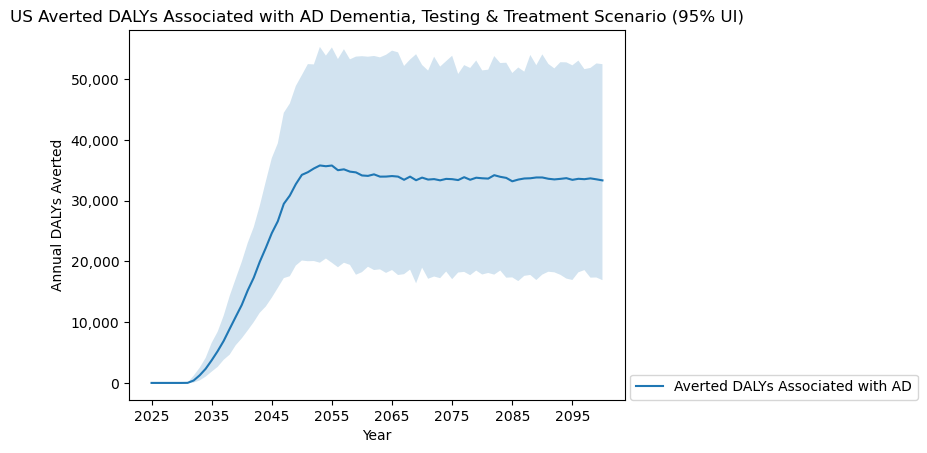

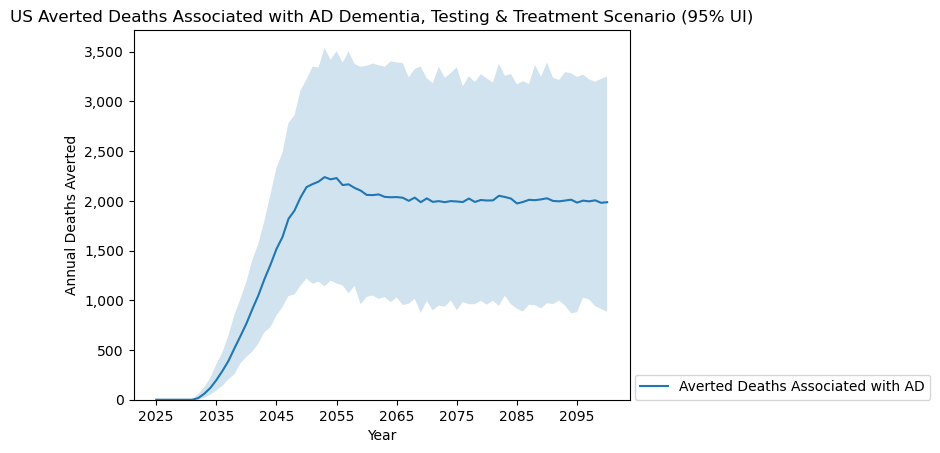

<Figure size 640x480 with 0 Axes>

In [195]:
make_forecast_plot(
    filter_results(
        res3,
        ["Year"],
        location=["United States of America"],
        measure=[
            "Averted DALYs Associated with AD",
        ],
        scenario=["BBBM Testing and Treatment"],
    ),
    "US Averted DALYs Associated with AD Dementia, Testing & Treatment Scenario (95% UI)",
    "Annual DALYs Averted",
    "Measure",
)
make_forecast_plot(
    filter_results(
        res3,
        ["Year"],
        location=["United States of America"],
        measure=[
            "Averted Deaths Associated with AD",
        ],
        scenario=["BBBM Testing and Treatment"],
    ),
    "US Averted Deaths Associated with AD Dementia, Testing & Treatment Scenario (95% UI)",
    "Annual Deaths Averted",
    "Measure",
)

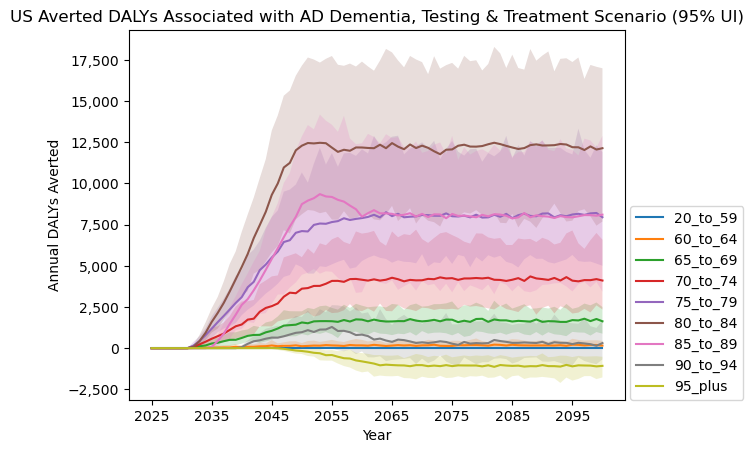

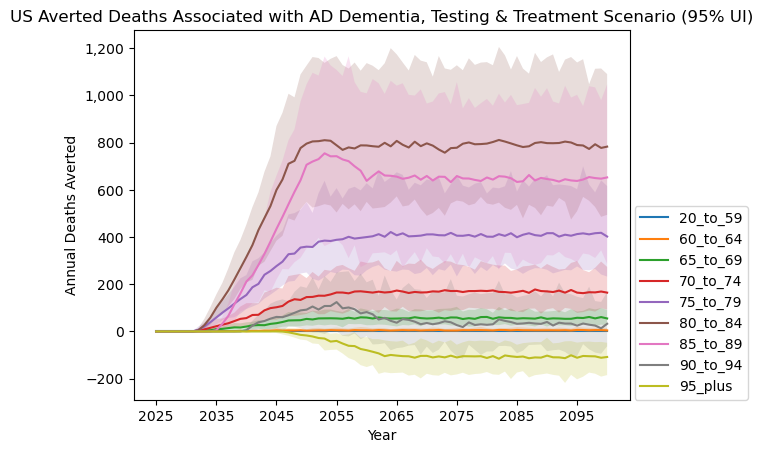

<Figure size 640x480 with 0 Axes>

In [196]:
make_forecast_plot(
    filter_results(
        res3,
        ["Year", "Age"],
        location=["United States of America"],
        measure=["Averted DALYs Associated with AD"],
        scenario=["BBBM Testing and Treatment"],
    ),
    "US Averted DALYs Associated with AD Dementia, Testing & Treatment Scenario (95% UI)",
    "Annual DALYs Averted",
    "Age",
)
make_forecast_plot(
    filter_results(
        res3,
        ["Year", "Age"],
        location=["United States of America"],
        measure=["Averted Deaths Associated with AD"],
        scenario=["BBBM Testing and Treatment"],
    ),
    "US Averted Deaths Associated with AD Dementia, Testing & Treatment Scenario (95% UI)",
    "Annual Deaths Averted",
    "Age",
)

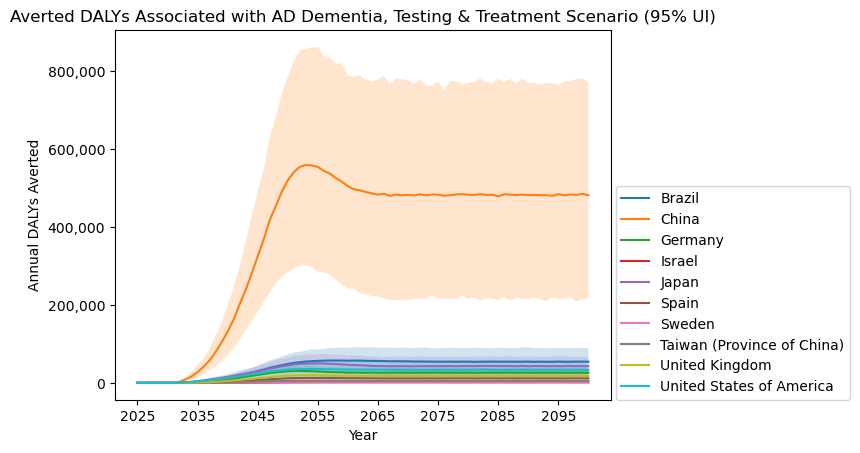

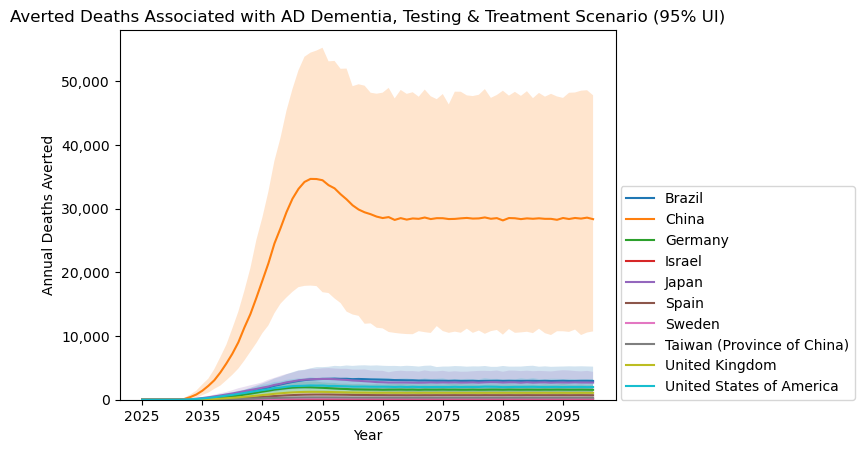

<Figure size 640x480 with 0 Axes>

In [62]:
make_forecast_plot(
    filter_results(
        res3,
        ["Year", "Location"],
        measure=[
            "Averted DALYs Associated with AD",
        ],
        scenario=["BBBM Testing and Treatment"],
    ),
    "Averted DALYs Associated with AD Dementia, Testing & Treatment Scenario (95% UI)",
    "Annual DALYs Averted",
    "Location",
)
make_forecast_plot(
    filter_results(
        res3,
        ["Year", "Location"],
        measure=[
            "Averted Deaths Associated with AD",
        ],
        scenario=["BBBM Testing and Treatment"],
    ),
    "Averted Deaths Associated with AD Dementia, Testing & Treatment Scenario (95% UI)",
    "Annual Deaths Averted",
    "Location",
)

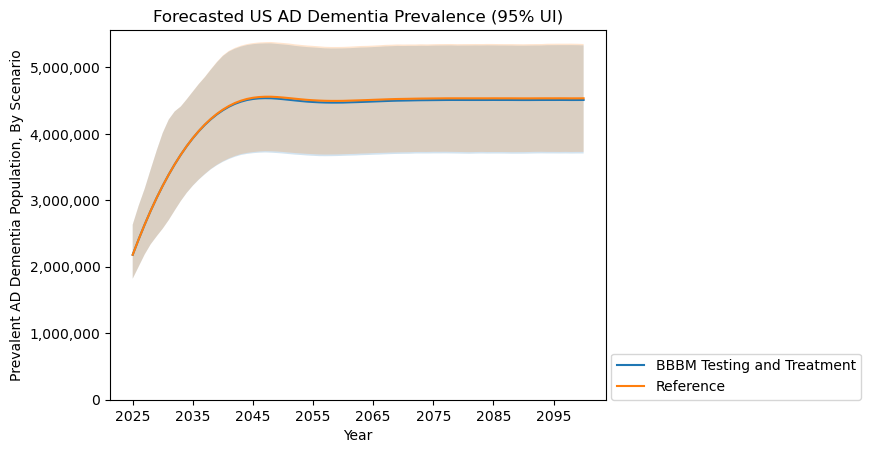

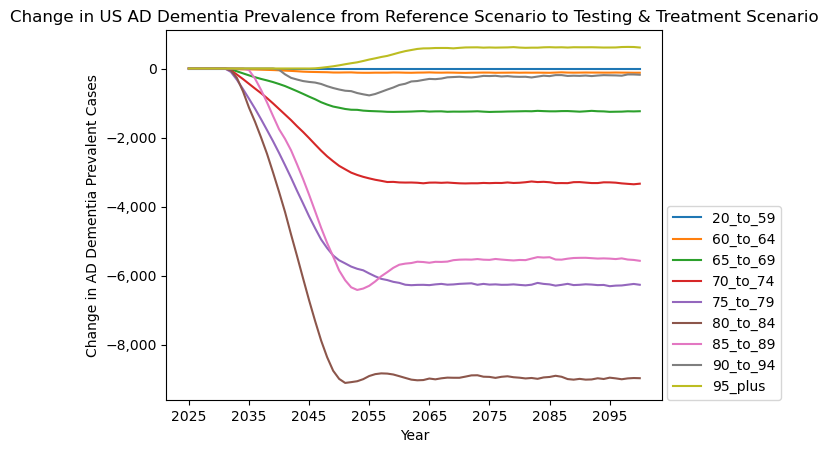

<Figure size 640x480 with 0 Axes>

In [ ]:
make_forecast_plot(
    filter_results(
        res,
        ["Year", "Scenario"],
        location=["United States of America"],
        stage=["AD Dementia"],
        measure=["Prevalence"],
        scenario=["Reference", "BBBM Testing and Treatment"],
    ),
    "Forecasted US AD Dementia Prevalence (95% UI)",
    "Prevalent AD Dementia Population, By Scenario",
    "Scenario",
)
df = filter_results(
    res,
    ["Year", "Age", "Scenario"],
    location=["United States of America"],
    stage=["AD Dementia"],
    measure=["Prevalence"],
    scenario=["Reference", "BBBM Testing and Treatment"],
)
df = df.set_index(
    list(df.columns.difference(["Mean", "95% UI Lower", "95% UI Upper"]))
).unstack("Scenario")

for x in ["Mean", "95% UI Lower", "95% UI Upper"]:
    df[(x, "Difference")] = df[(x, "BBBM Testing and Treatment")] - df[(x, "Reference")]
    df = df.drop(
        [(x, "BBBM Testing and Treatment"), (x, "Reference")],
        axis=1,
    )
df = (
    df.droplevel("Scenario", axis=1)
    .reset_index()
    .drop(["95% UI Lower", "95% UI Upper"], axis=1)
)
make_forecast_plot(
    df,
    "Change in US AD Dementia Prevalence from Reference Scenario to Testing & Treatment Scenario",
    "Change in AD Dementia Prevalent Cases",
    "Age",
)